### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [1]:
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
import matplotlib.pyplot as plt
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



670752


In [45]:
import os, json

animal = 13
TEST_DATA = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,animal)[:,:,0,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)

def load_best_hp(animal, out_dir):
    """Return (best_hp: dict, best_ll: float) for this animal."""
    json_path = os.path.join(out_dir, f"animal_{animal:02d}.json")
    with open(json_path, "r") as f:
        data = json.load(f)
    return data["best_hp"], float(data["best_ll"])
best_hp, best_ll = load_best_hp(animal, "hp_runs/sated")


In [ ]:
print(animal, best_ll)
for k, v in best_hp.items():
    print(f"{k:8s} = {v}")

13 -inf


AttributeError: 'NoneType' object has no attribute 'items'

: 

In [11]:
def hp_internal_to_user(hp_int: dict) -> dict:
    """Convert evaluator/random_search dict -> your preferred schema."""
    return {
        "sigma_m": float(hp_int["l_gp_a"]),
        "gamma_gp": float(hp_int["g_gp_a"]),
        "beta_gp": float(hp_int["b_gp_a"]),
        "sigma_c": float(hp_int["l_wp_a"]),
        "gamma_wp": float(hp_int["g_wp_a"]),
        "beta_wp": float(hp_int["b_wp_a"]),
        "p": int(hp_int["p"]),
    }
hyperparams = hp_internal_to_user(best_hp)

In [ ]:
old_hyperparams = {
    'sigma_m':2.4886496,
    'gamma_gp': 0.00016234,
    'beta_gp': 0.24385944,
    'sigma_c': 0.28382865,
    'gamma_wp':0.00044405,
    'beta_wp':1.0398238,
    'p': 0,
}

In [12]:
# Initialise Kernel and Model
periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_m']))
periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_c']))

In [14]:

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=periodic_kernel_gp,N=N)
# wp = models.WishartProcess(kernel =periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
wp = models.WishartLRDProcess(kernel=periodic_kernel_wp,P=hyperparams['p'],V=1e-1*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)

Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [15]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,TEST_RESPONSE,n_iter = 6000,key=key)
joint.update_params(varfam.posterior)
posterior = models.NormalGaussianWishartPosterior(joint, varfam, X_CONDITIONS)

/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/6000 [00:00<?, ?it/s]/home/scastedo/miniforge3/envs/wishart/lib/python3.13/site-packages/jax/_src/linear_util.py:370: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = _fun(*args, **kwargs)
100%|██████████| 6000/6000 [00:30<00:00, 196.51it/s, init loss: 16729976.1859, avg. loss [5701-6000]: -17953.8233]


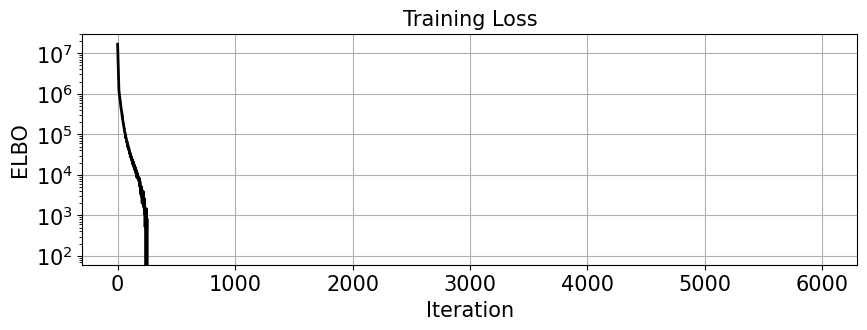

In [16]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


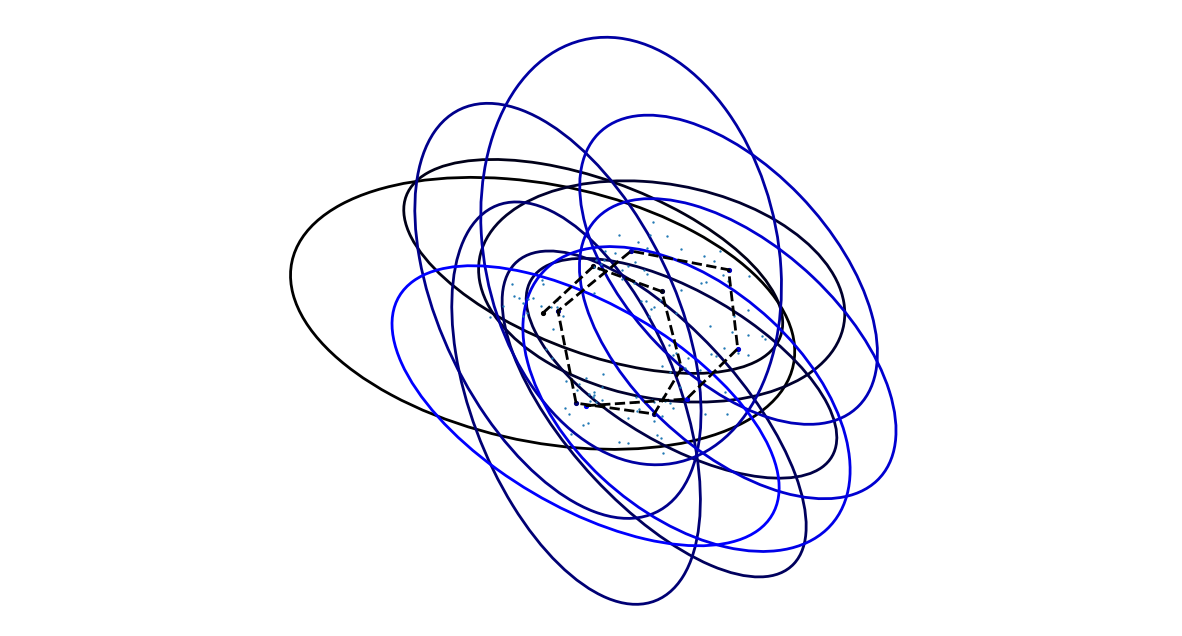

In [17]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


# Compare to Empirical

(12, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


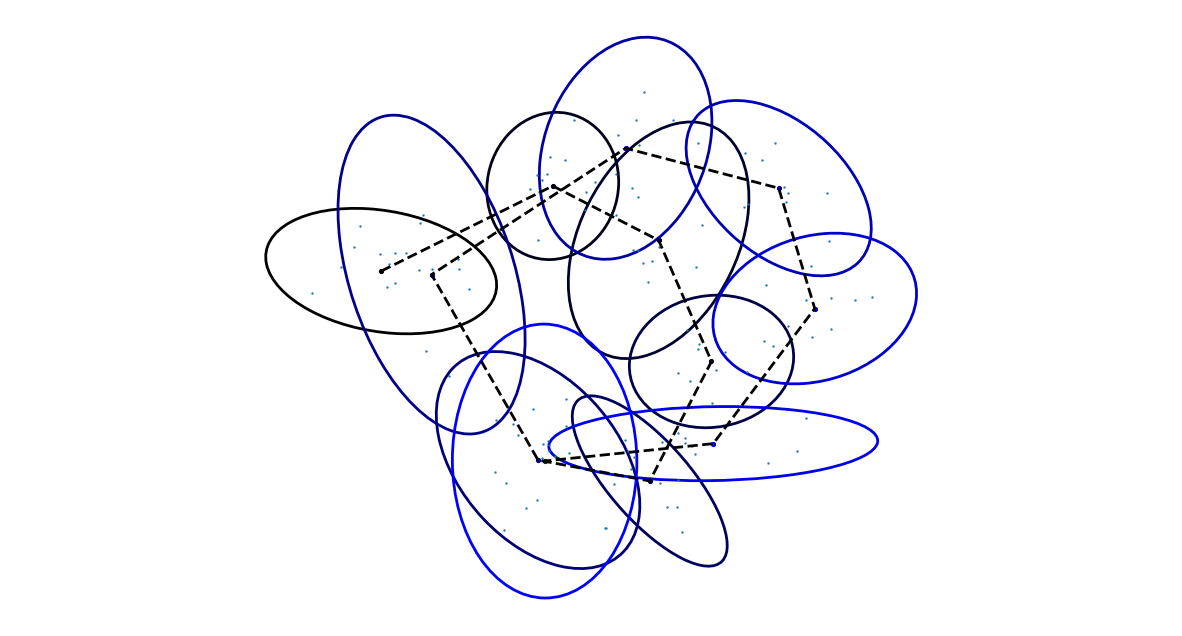

In [18]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)



# Test Unseen conditions 

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


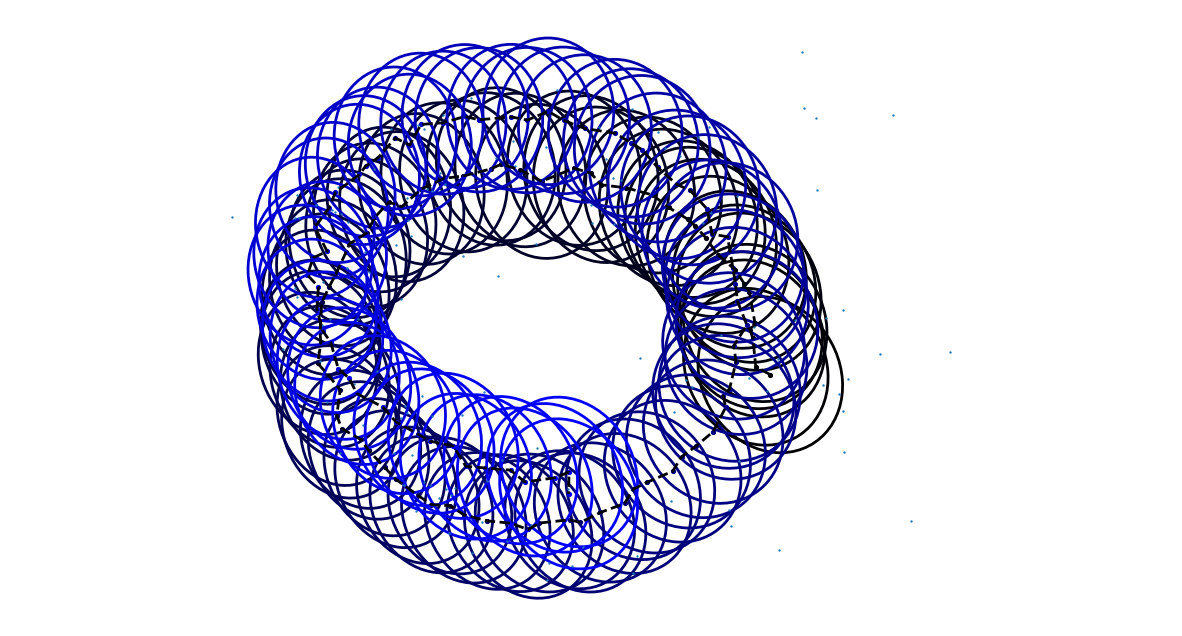

In [47]:
with numpyro.handlers.seed(rng_seed=1):
    X_TEST_CONDITIONS = jnp.linspace(0, C-1, 120)
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(X_TEST_CONDITIONS)

    visualizations.visualize_pc(
        mu_test_hat[:,None],sigma_test_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
    )
